In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from heatmap import HeatMap as hm
import h5py
import matplotlib.animation as animation
from simulation import individual_simulation as sim_
import matplotlib.gridspec as gridspec
import tensorflow as tf

In [25]:
def cost_col(path, name, range_):
    cost = []
    time = []
    total_slices = 0
    num_cost = []
    data = h5py.File(path + name + f"{3}.h5", "r")
    target = data["target"][:]
    for i in range(range_[0], range_[1]):
        data = h5py.File(path + name + f"{i}.h5", "r")
        time.extend(data["time"])
        cost.extend(list(data["cost"]))
        num_cost.append(len(list(data["cost"])))
        data.close()

    res_ = np.zeros((len(cost), 100, 100))

    inx = 0
    h = 0
    #for j in range(range_[0], range_[1]):
        #data = h5py.File(path + name + f"{j}.h5", "r")
        #d, z, y, x = data["results"].shape
        #res_[inx:inx + num_cost[h], :, :] = data["results"][:num_cost[h], :, :] 
        #inx += num_cost[h]
        #h += 1
        #data.close()

    return cost, res_, target, time   

In [26]:
# check the files pathway
path = "/home/samani/Documents/projects/master_project/model/results/model_4/"
#file = h5py.File(path, "r")
ind = file["ind"][:]
#results = file["results"][:]
#print(file.keys())

In [27]:
# data extraction from the files
name = "rings"
cost, res_, target, time = cost_col(path=path, name=name, range_=(1, 8))

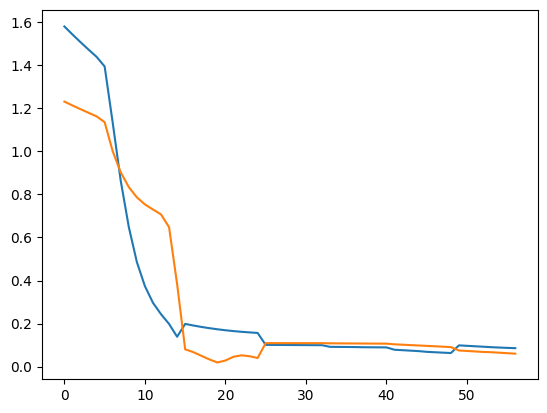

In [101]:
c1 = []
c2 = []
for i in range(57):
    c1.append(cost[i][0])
    c2.append(cost[i][1])


plt.plot(c1)
plt.plot(c2)

In [65]:
res_ = []
for i in range(1, 8, 1):
    file = h5py.File(path+f"rings{i}.h5", "r")
    res_.append(file["results"])

# Selecting subsets of each result
r = [] 
r.append(res_[0][:, :5, :, :])
r.append(res_[1][:, :10, :, :])
r.append(res_[2][:, :10, :, :])
r.append(res_[3][:, :8, :, :])
r.append(res_[4][:, :8, :, :])
r.append(res_[5][:, :8, :, :])
r.append(res_[6][:, :8, :, :])

# Initialize an array to store the combined results
g = np.zeros((2, 57, 100, 100))  # 57 is the total time steps from all r[i]

count = 0  # Starting position in the g array for time steps
for i in range(len(r)):
    # Determine the number of time steps for the current r[i]
    num_time_steps = r[i].shape[1]
    
    # Assign the result to g, using cumulative count for the slice
    g[:, count:count + num_time_steps, :, :] = r[i]
    
    # Update the count by the number of time steps just added
    count += num_time_steps



In [68]:
print(g[-1, 0, :, :])
    

[[1.26907143 1.35502622 1.02338464 ... 0.98690478 0.7188255  0.97838418]
 [1.13098183 0.82437619 0.88966114 ... 0.78957124 0.49638294 0.97239871]
 [1.34745481 1.28345024 1.14847887 ... 0.50742212 0.42839737 0.57584614]
 ...
 [0.59373846 0.81619867 1.1239565  ... 0.55940598 0.76114372 0.61716043]
 [0.52199541 0.9724359  1.07487916 ... 0.72365303 0.82596491 0.94791346]
 [0.54383624 0.53815809 0.65995611 ... 1.11937962 0.81518303 0.49605109]]


<Axes: >

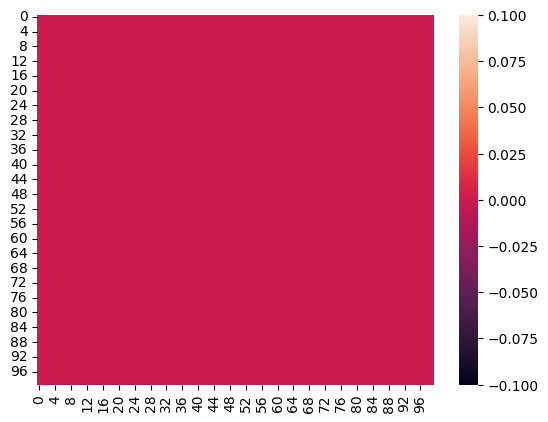

In [61]:
sns.heatmap(g[0, -2, :, :])

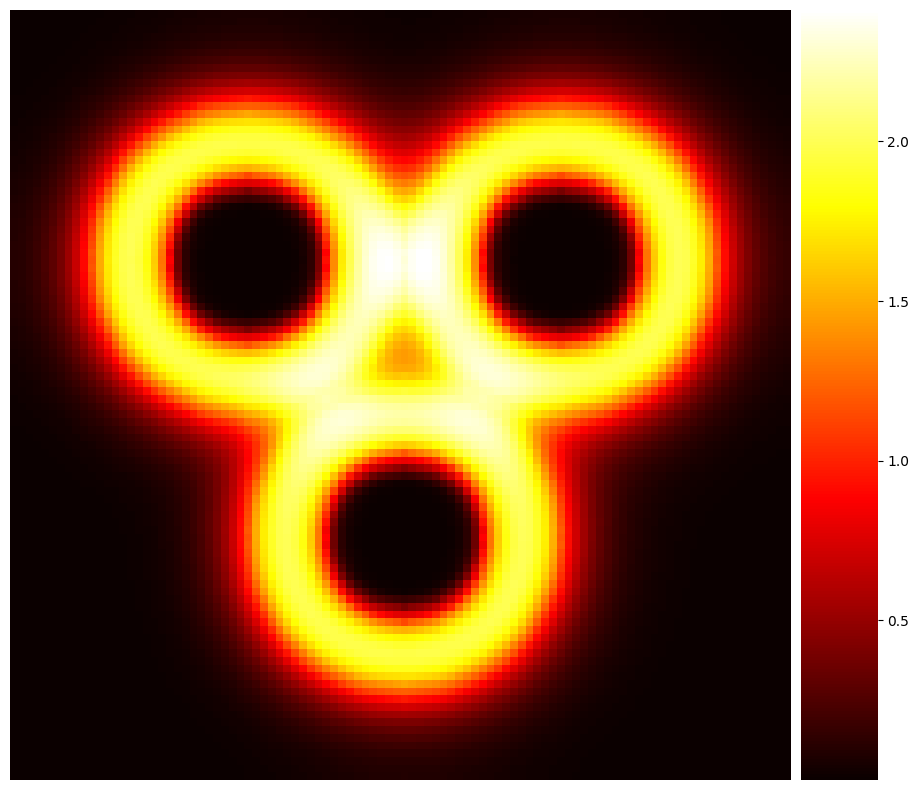

<Figure size 640x480 with 0 Axes>

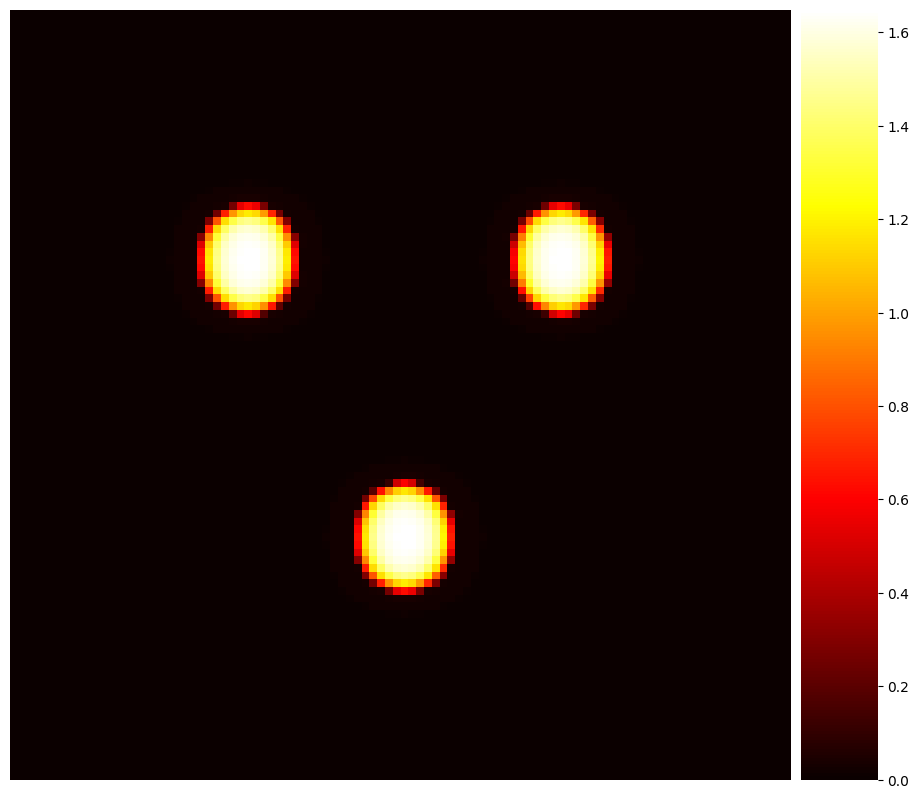

<Figure size 640x480 with 0 Axes>

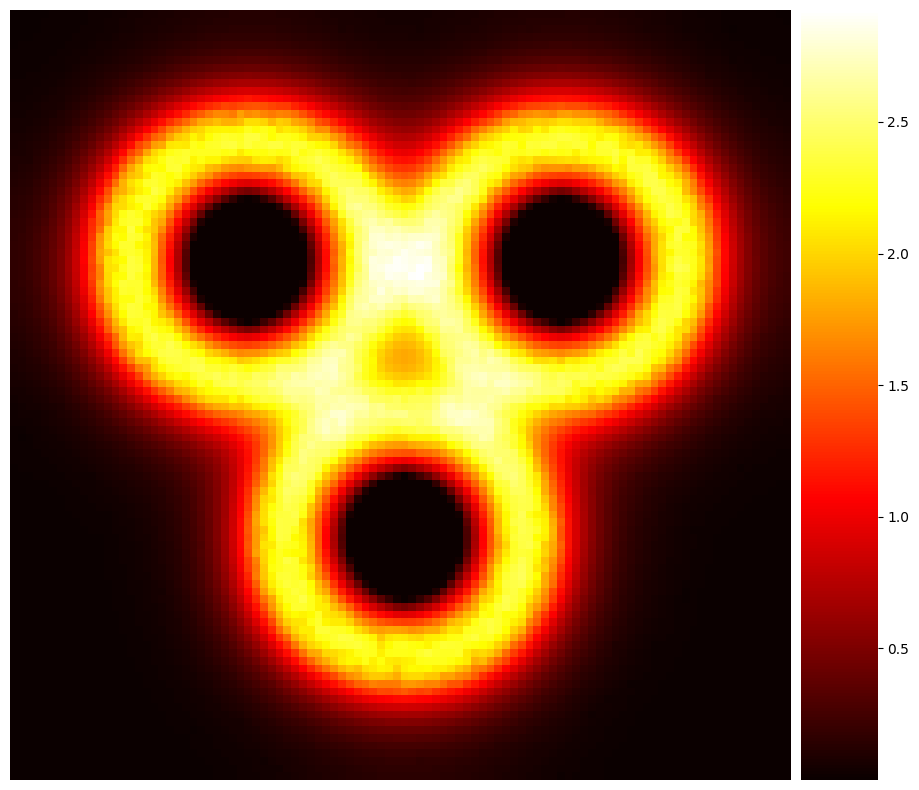

<Figure size 640x480 with 0 Axes>

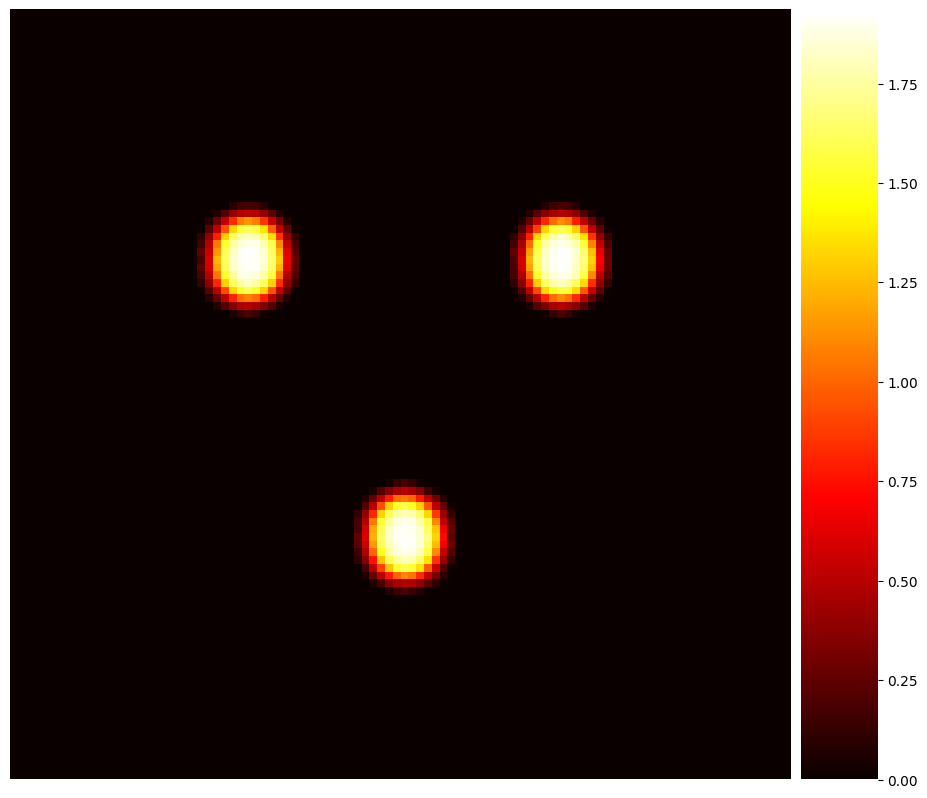

<Figure size 640x480 with 0 Axes>

In [92]:
# target heatmap (inferno, plasma, cividis, viridis, magma and hot)
plt.figure(figsize=(12, 10))
sns.heatmap(target[0], cmap="hot", cbar_kws={"aspect": 10, "pad": 0.01})
plt.axis('off')
plt.savefig("/home/samani/Documents/projects/master_project/model/results/model_4/target1.png")
plt.show()
plt.clf()

plt.figure(figsize=(12, 10))
sns.heatmap(target[1], cmap="hot", cbar_kws={"aspect": 10, "pad": 0.01})
plt.axis('off')
plt.savefig(r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_4\target2.png")
plt.show()
plt.clf()


plt.figure(figsize=(12, 10))
sns.heatmap(g[0, -1, :, :], cmap="hot", cbar_kws={"aspect": 10, "pad": 0.01})
plt.axis('off')
plt.savefig("/home/samani/Documents/projects/master_project/model/results/model_4/y_hat1.png")
plt.show()
plt.clf()

plt.figure(figsize=(12, 10))
sns.heatmap(g[1, -1, :, :], cmap="hot", cbar_kws={"aspect": 10, "pad": 0.01})
plt.axis('off')
plt.savefig(r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_4\y_hat2.png")
plt.show()
plt.clf()

In [16]:
# cost cleaning
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
sm_ = moving_average(c_final, window_size=5)

245


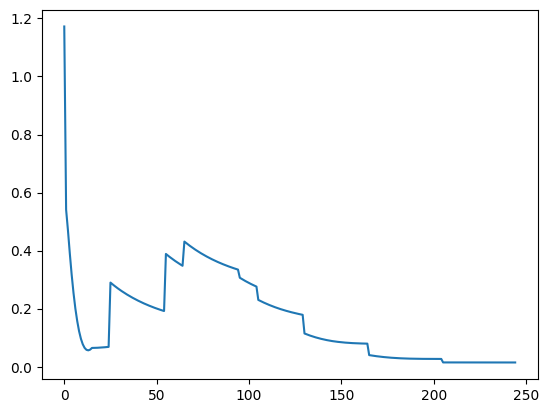

In [62]:
c1 = cost[:3]
c2 = cost[68:]
c_final = c1 + c2
plt.plot(cost)
print(len(cost))

(245, 100, 100)


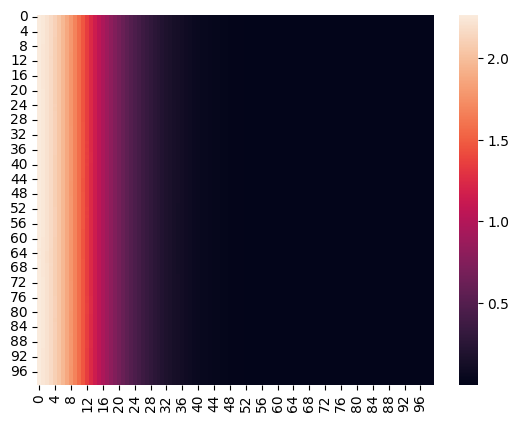

In [36]:
sns.heatmap(res_[-1, :, :])
print(res_.shape)

In [76]:
# heat map video
def generate_heatmap_video(results, cmap='plasma', save_path='heatmap_video.mp4', dpi=300, fps=10, bitrate=2000,
                           cbar_shrink=0.8, cbar_aspect=20, cbar_pad=0.01):
    iterations, y, x = results.shape
    fig = plt.figure(figsize=(10, 8), dpi=dpi)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.02], wspace=0.02)
    ax = fig.add_subplot(gs[0, 0]) 
    cbar_ax = fig.add_subplot(gs[0, 1])
    cax = ax.imshow(results[0, :, :], cmap=cmap, vmin=np.min(results), vmax=np.max(results))
    fig.colorbar(cax, cax=cbar_ax, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)

    ax.set_xticks([])
    ax.set_yticks([])

    def update(i):
        cax.set_data(results[i, :, :])
        ax.set_title(f"Iteration {i}")
        
    ani = animation.FuncAnimation(fig, update, frames=iterations, repeat=False)
    ani.save(save_path, writer='ffmpeg', fps=fps, bitrate=bitrate, dpi=dpi)

    plt.close()

In [82]:
generate_heatmap_video(g[1, :, :, :], cmap='hot', save_path='heatmap_video.mp4', dpi=500, fps=5, bitrate=5000,
                           cbar_shrink=0.8, cbar_aspect=20, cbar_pad=0.01)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

def generate_heatmap_video_dual(results1, results2, cmap1='plasma', cmap2='hot', save_path='heatmap_video.mp4',
                                dpi=300, fps=10, bitrate=2000, cbar_shrink=0.8, cbar_aspect=20, cbar_pad=0.01):
    # Ensure both result arrays have the same shape for proper overlay
    assert results1.shape == results2.shape, "Results must have the same shape."

    iterations, y, x = results1.shape

    # Create a figure and grid spec layout for the heatmaps and colorbars
    fig = plt.figure(figsize=(10, 8), dpi=dpi)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.02, 0.02], wspace=0.02)
    ax = fig.add_subplot(gs[0, 0]) 
    cbar_ax1 = fig.add_subplot(gs[0, 1])
    cbar_ax2 = fig.add_subplot(gs[0, 2])

    # Set up the heatmap for the first result set (results1)
    cax1 = ax.imshow(results1[0, :, :], cmap=cmap1, vmin=np.min(results1), vmax=np.max(results1), alpha=0.6)
    fig.colorbar(cax1, cax=cbar_ax1, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)

    # Overlay the heatmap for the second result set (results2) with a different colormap
    cax2 = ax.imshow(results2[0, :, :], cmap=cmap2, vmin=np.min(results2), vmax=np.max(results2), alpha=0.4)
    fig.colorbar(cax2, cax=cbar_ax2, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Update function for each frame of the animation
    def update(i):
        # Update the data for both heatmaps
        cax1.set_data(results1[i, :, :])
        cax2.set_data(results2[i, :, :])
        ax.set_title(f"Iteration {i}")

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=iterations, repeat=False)
    
    # Save the animation
    ani.save(save_path, writer='ffmpeg', fps=fps, bitrate=bitrate, dpi=dpi)

    plt.close()

# Call the function using both parts of g
generate_heatmap_video_dual(g[0, :, :, :], g[1, :, :, :], cmap1='plasma', cmap2='hot', save_path='dual_heatmap_video.mp4',
                            dpi=300, fps=10, bitrate=2000, cbar_shrink=0.8, cbar_aspect=20, cbar_pad=0.01)


In [69]:
generate_heatmap_video(
    res_, cmap='hot', save_path='model_3.mp4',dpi=300, fps=10, bitrate=2000,
    cbar_shrink=0.8, cbar_aspect=0, cbar_pad=0.01)

In [81]:
data = h5py.File("/home/samani/Documents/projects/master_project/model/results/model_3/datasets10.h5")
print(data.keys())
ind = data["ind"]
print(ind.shape)

<KeysViewHDF5 ['cost', 'ind', 'results', 'target', 'time']>
(3, 100, 100)


In [45]:
print(res_.shape)

(245, 100, 100)


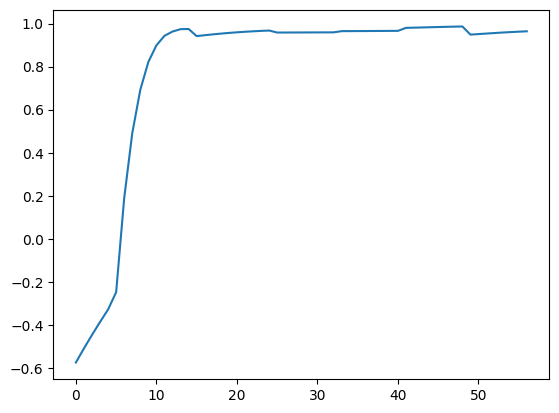

In [93]:
# calculate accuracies

acc1 = []
for i in range(57):
    mse = np.mean((g[0, i, :, :] - target[0]) ** 2)
    max_possible_error = 1 ** 2
    accuracy = 1 - mse / max_possible_error
    acc1.append(accuracy)
plt.plot(acc1)

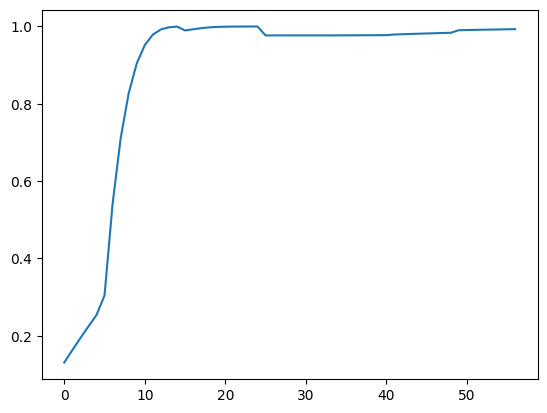

In [94]:
acc2 = []
for i in range(57):
    mse = np.mean((g[1, i, :, :] - target[1]) ** 2)
    max_possible_error = 1 ** 2
    accuracy = 1 - mse / max_possible_error
    acc2.append(accuracy)
plt.plot(acc2)

In [110]:
accc = np.zeros((2, 57))
for i in range(57):
    accc[0, i] = acc1[i]
    accc[1, i] = acc2[i]
    

In [78]:
# cost animation
def generate_cost_accuracy_animation(costs, accuracies, save_path='cost_accuracy_progression.gif', dpi=300, fps=10, bitrate=2000):
    
    fig, ax = plt.subplots(figsize=(16, 6), dpi=dpi)
    ax.set_xlim(-5, len(costs)+5)  
    ax.set_ylim(-.05, 1.2)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Values")
    
    cost_line, = ax.plot([], [], lw=4, color='darkred', label="Cost") 
    accuracy_line, = ax.plot([], [], lw=4, color='gold', label="Accuracy")

    cost_point = ax.plot([], [], marker='o', color='darkred', markersize=10)[0]  
    accuracy_point = ax.plot([], [], marker='o', color='gold', markersize=10)[0]  

    title = ax.text(0.5, 1.2, '', transform=ax.transAxes, ha="center", fontsize=16)
    ax.legend(loc='upper right')

    def init():
        cost_line.set_data([], [])
        accuracy_line.set_data([], [])
        cost_point.set_data([], [])
        accuracy_point.set_data([], [])
        title.set_text('')
        return cost_line, accuracy_line, cost_point, accuracy_point, title

    def update(i):
        x = np.arange(i + 1) 
        cost_y = costs[:i + 1]  
        accuracy_y = accuracies[:i + 1] 
        cost_line.set_data(x, cost_y)
        accuracy_line.set_data(x, accuracy_y)
        cost_point.set_data(i, costs[i]) 
        accuracy_point.set_data(i, accuracies[i]) 
        title.set_text(f"Cost & Accuracy - {i}")
        return cost_line, accuracy_line, cost_point, accuracy_point, title

    ani = animation.FuncAnimation(fig, update, frames=len(costs), init_func=init, blit=True, repeat=False)
    ani.save(save_path, writer='ffmpeg', fps=fps)
    plt.close()

In [ ]:
generate_cost_accuracy_animation(cost, accuracies, save_path='cost_accuracy_progression1_.mp4')import numpy as np

In [107]:


def generate_cost_accuracy_animation1(costs1, accuracies1, costs2, accuracies2, 
                                     save_path='cost_accuracy_progression.gif', dpi=300, fps=3):
    
    fig, ax = plt.subplots(figsize=(16, 6), dpi=dpi)
    ax.set_xlim(-2, max(len(costs1), len(costs2))+2)  # Adjust x-axis to fit both cost arrays
    ax.set_ylim(-.05, 1.7)  # Adjust y-axis as needed
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Values")
    
    # Line for Cost 1 and Accuracy 1
    cost_line1, = ax.plot([], [], lw=4, color='lightcoral', label="Cost 1") 
    accuracy_line1, = ax.plot([], [], lw=4, color='gold', label="Accuracy 1")

    # Line for Cost 2 and Accuracy 2
    cost_line2, = ax.plot([], [], lw=4, color='darkred', label="Cost 2")
    accuracy_line2, = ax.plot([], [], lw=4, color='darkorange', label="Accuracy 2")

    # Markers for the points
    cost_point1 = ax.plot([], [], marker='o', color='lightcoral', markersize=10)[0]  
    accuracy_point1 = ax.plot([], [], marker='o', color='gold', markersize=10)[0]  

    cost_point2 = ax.plot([], [], marker='o', color='darkred', markersize=10)[0]
    accuracy_point2 = ax.plot([], [], marker='o', color='darkorange', markersize=10)[0]

    title = ax.text(0.5, 1.2, '', transform=ax.transAxes, ha="center", fontsize=16)
    ax.legend(loc='upper right')

    def init():
        # Initialize empty lines and points
        cost_line1.set_data([], [])
        accuracy_line1.set_data([], [])
        cost_line2.set_data([], [])
        accuracy_line2.set_data([], [])
        cost_point1.set_data([], [])
        accuracy_point1.set_data([], [])
        cost_point2.set_data([], [])
        accuracy_point2.set_data([], [])
        title.set_text('')
        return cost_line1, accuracy_line1, cost_line2, accuracy_line2, cost_point1, accuracy_point1, cost_point2, accuracy_point2, title

    def update(i):
        # Define x values (iterations)
        x1 = np.arange(min(i + 1, len(costs1)))  # Ensure the array index doesn't exceed its length
        x2 = np.arange(min(i + 1, len(costs2)))

        # Update y values for each cost/accuracy array
        cost_y1 = costs1[:i + 1]
        accuracy_y1 = accuracies1[:i + 1]
        cost_y2 = costs2[:i + 1]
        accuracy_y2 = accuracies2[:i + 1]

        # Set data for cost/accuracy 1
        cost_line1.set_data(x1, cost_y1)
        accuracy_line1.set_data(x1, accuracy_y1)
        cost_point1.set_data(i, costs1[min(i, len(costs1) - 1)])  # Ensure the index doesn't exceed
        accuracy_point1.set_data(i, accuracies1[min(i, len(accuracies1) - 1)])  

        # Set data for cost/accuracy 2
        cost_line2.set_data(x2, cost_y2)
        accuracy_line2.set_data(x2, accuracy_y2)
        cost_point2.set_data(i, costs2[min(i, len(costs2) - 1)])  # Ensure the index doesn't exceed
        accuracy_point2.set_data(i, accuracies2[min(i, len(accuracies2) - 1)])

        title.set_text(f"Iteration {i}")
        return cost_line1, accuracy_line1, cost_line2, accuracy_line2, cost_point1, accuracy_point1, cost_point2, accuracy_point2, title

    # Create animation with the number of frames being the maximum length of the cost arrays
    max_frames = max(len(costs1), len(costs2))
    ani = animation.FuncAnimation(fig, update, frames=max_frames, init_func=init, blit=True, repeat=False)

    # Save the animation
    ani.save(save_path, writer='ffmpeg', fps=fps)
    plt.close()

# Example usage:
# costs1 = np.random.rand(100)
# accuracies1 = np.random.rand(100)
# costs2 = np.random.rand(120)
# accuracies2 = np.random.rand(120)
# generate_cost_accuracy_animation(costs1, accuracies1, costs2, accuracies2, save_path='dual_cost_accuracy.mp4')


In [108]:
generate_cost_accuracy_animation1(costs1=c1, accuracies1=acc1, costs2=c2, accuracies2=acc2, save_path='dual_cost_accuracy.mp4')

/tmp/ipykernel_22294/1422757119.py:55: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cost_point1.set_data(i, costs1[min(i, len(costs1) - 1)])  # Ensure the index doesn't exceed
/tmp/ipykernel_22294/1422757119.py:56: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  accuracy_point1.set_data(i, accuracies1[min(i, len(accuracies1) - 1)])
/tmp/ipykernel_22294/1422757119.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cost_point2.set_data(i, costs2[min(i, len(costs2) - 1)])  # Ensure the index doesn't exceed
/tmp/ipykernel_22294/1422757119.py:62: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  accuracy_point2.set_data(i, accuracie

In [38]:
ac = data["accuracy"][:]/100
print(ac)

[0.45682758 0.47792765 0.49806327 0.51721372 0.53541085 0.55265625
 0.56900637 0.58452977 0.59924361 0.61320647 0.62645512 0.63901764
 0.65094171 0.66226026 0.672999   0.68319571 0.69288674 0.70208903
 0.71084248 0.71916342 0.7270847  0.73461647 0.74177734 0.74860193
 0.75510892 0.76131686 0.76723263 0.77287764 0.77826259 0.78340772
 0.78831969 0.79301384 0.79750113 0.80178694 0.80588193 0.80979792
 0.81354694 0.81714044 0.82058307 0.82388057 0.82704065 0.83007009
 0.83297496 0.83576298 0.83844077 0.84101355 0.84348664 0.84586416
 0.84814904 0.85034501 0.85245768 0.85449016 0.85644685 0.85833078
 0.86014658 0.81592828 0.82460233 0.83284873 0.84063206 0.84794073
 0.854805   0.86124502 0.86728888 0.87295818 0.8782914  0.88329555
 0.8880032  0.89242432 0.89657821 0.90048298 0.9041611  0.90761962
 0.91087342 0.91393787 0.91682769 0.92705239 0.93110104 0.93492755
 0.93851113 0.94186609 0.94499735 0.94791534 0.95063439 0.9531629
 0.9555148  0.95771042 0.95975265 0.96165526 0.96343054 0.96508

In [112]:
# store the cleaned data
with h5py.File("/home/samani/Documents/projects/master_project/model/results/model_4/data.h5", 'a') as h5file:
    h5file.create_dataset("ind", data=ind)
    h5file.create_dataset("time", data=np.array(time))
    h5file.create_dataset("cost", data=np.array(cost))
    h5file.create_dataset("target", data=target)
    h5file.create_dataset("y_hat", data=g)
    h5file.create_dataset("accuracy", data=accc)
    